<a href="https://colab.research.google.com/github/arlo7777/Project-MIT-Columbia/blob/main/PE_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,15)
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import SCORERS

In [ ]:
df = pd.read_excel('Data Series Final Draft.xlsx')

In [ ]:
df.columns

Index(['Name', 'Asset Class', 'Vintage/Inception Year', 'Strategy',
       'Final Close Size', 'Net IRR %', 'Net Multiple (X)', 'RVPI %',
       'DPI (%)', 'Called %', 'Quartile Rank', 'Date Reported', 'Status',
       'Geographic Focus', 'Fund Manager', 'Country', 'Core Industries',
       'Industry Verticals', 'Fund Number (Overall)', 'Fund Number (Series)',
       'Industries', 'Date 10-yr Treasury', '10-yr Treasury (Adj Close)',
       'Date MSCI', 'MSCI (Adj Close)'],
      dtype='object')

In [ ]:
date_df = df[['Date 10-yr Treasury', '10-yr Treasury (Adj Close)', 'Date MSCI', 'MSCI (Adj Close)']]
df  = df.drop(columns=['Date 10-yr Treasury', '10-yr Treasury (Adj Close)', 'Date MSCI', 'MSCI (Adj Close)'])

In [ ]:
date_df['Treasury_year'] = pd.to_datetime(date_df['Date 10-yr Treasury']).dt.year
date_df['MSCI_year'] = pd.to_datetime(date_df['Date MSCI']).dt.year

In [ ]:
treasury_per_year = date_df.groupby(['Treasury_year']).agg({'10-yr Treasury (Adj Close)':'mean'}).reset_index()
msci_per_year = date_df.groupby(['MSCI_year']).agg({'MSCI (Adj Close)':'mean'}).reset_index()
msci_per_year 
treasury_per_year

,Treasury_year,10-yr Treasury (Adj Close)
0,1985.0,10.535833
1,1986.0,7.570000
2,1987.0,8.412500
3,1988.0,8.830833
4,1989.0,8.452500
5,1990.0,8.557500
6,1991.0,7.789167
7,1992.0,7.030000
8,1993.0,5.842167
9,1994.0,7.120417


In [ ]:

df = pd.merge(df,msci_per_year, left_on='Vintage/Inception Year', right_on='MSCI_year', how='left' )

df = pd.merge(df,treasury_per_year, left_on='Vintage/Inception Year', right_on='Treasury_year', how='left' )

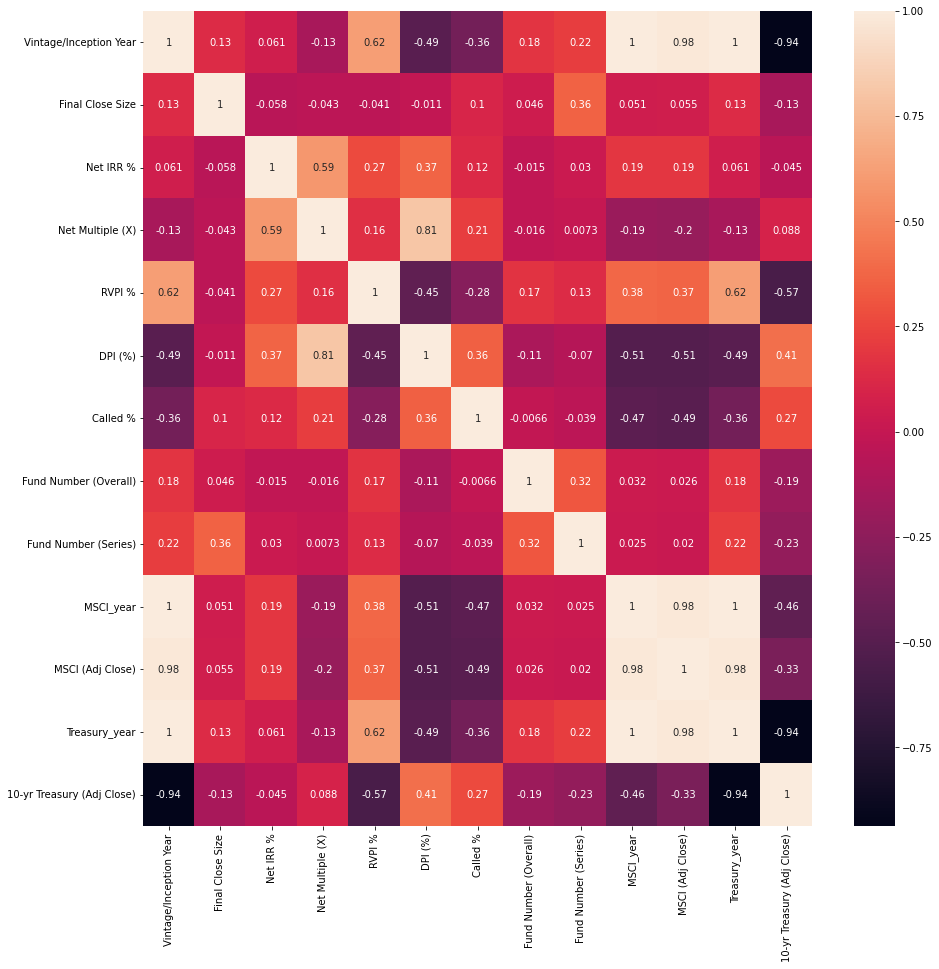

In [ ]:
sns.heatmap(df.corr(), annot=True)

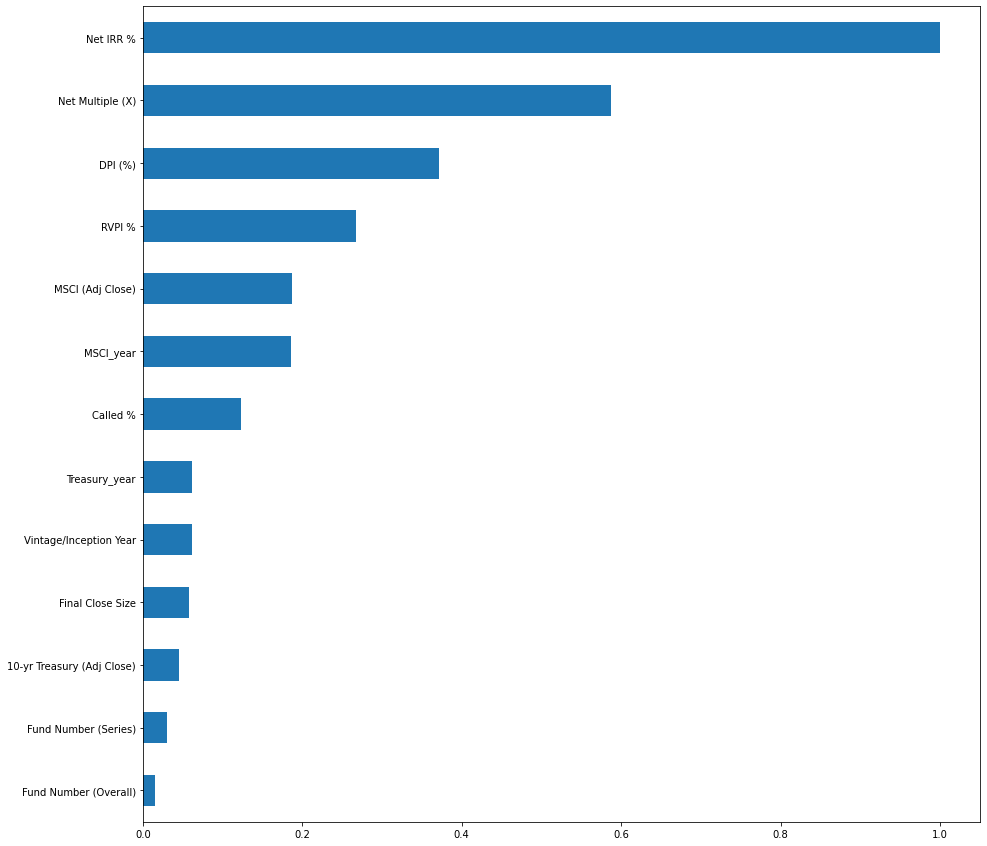

In [ ]:
abs(df.corr()['Net IRR %']).sort_values().plot.barh()

In [ ]:
summary_stats  = df.describe(include='all')
summary_stats 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,Name,Asset Class,Vintage/Inception Year,Strategy,Final Close Size,Net IRR %,Net Multiple (X),RVPI %,DPI (%),Called %,...,Country,Core Industries,Industry Verticals,Fund Number (Overall),Fund Number (Series),Industries,MSCI_year,MSCI (Adj Close),Treasury_year,10-yr Treasury (Adj Close)
count,907,907,907.000000,907,901.000000,789.000000,844.000000,855.000000,859.000000,879.000000,...,907,907,907,907.000000,901.000000,897,441.000000,441.000000,907.000000,907.000000
unique,907,1,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,...,46,16,57,NaN,NaN,653,NaN,NaN,NaN,NaN
top,Agilitas 2020 Private Equity Fund SCSp,Private Equity,NaN,Buyout,NaN,NaN,NaN,NaN,NaN,NaN,...,US,Diversified,Manufacturing,NaN,NaN,"Consumer Services, Logistics & Distribution",NaN,NaN,NaN,NaN
freq,1,907,NaN,585,NaN,NaN,NaN,NaN,NaN,NaN,...,520,613,585,NaN,NaN,29,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2008.080485,NaN,297.529223,16.697698,1.813024,55.983138,124.796456,88.640238,...,NaN,NaN,NaN,3.545755,2.499445,NaN,2014.240363,31.790398,2008.080485,3.769547
std,NaN,NaN,7.368653,NaN,242.962537,21.614580,1.042220,68.603600,114.944185,23.735285,...,NaN,NaN,NaN,5.108627,1.670412,NaN,3.210962,11.871120,7.368653,1.591439
min,NaN,NaN,1985.000000,NaN,5.400000,-100.000000,0.000000,0.000000,0.000000,0.614286,...,NaN,NaN,NaN,1.000000,1.000000,NaN,2009.000000,17.906046,1985.000000,0.816250
25%,NaN,NaN,2004.000000,NaN,107.000000,6.900000,1.179347,0.000000,32.335044,81.728291,...,NaN,NaN,NaN,1.000000,1.000000,NaN,2011.000000,19.073668,2004.000000,2.359000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907 entries, 0 to 906
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Name                        907 non-null    object        
 1   Asset Class                 907 non-null    object        
 2   Vintage/Inception Year      907 non-null    int64         
 3   Strategy                    907 non-null    object        
 4   Final Close Size            901 non-null    float64       
 5   Net IRR %                   789 non-null    float64       
 6   Net Multiple (X)            844 non-null    float64       
 7   RVPI %                      855 non-null    float64       
 8   DPI (%)                     859 non-null    float64       
 9   Called %                    879 non-null    float64       
 10  Quartile Rank               598 non-null    object        
 11  Date Reported               907 non-null    datetime64[ns]

In [ ]:
numerical_columns = [i for i in df.columns if df[i].dtype not in ('datetime64[ns]', 'object')]
numerical_columns.remove('Net IRR %')

In [ ]:
categorical_columns = list(summary_stats.loc['unique'].index[list(summary_stats.loc['unique'].values < 17)])
categorical_columns.remove('Asset Class')





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [ ]:
drop_columns = list(set(df.columns).difference((set(numerical_columns).union(categorical_columns))))
drop_columns.remove('Net IRR %')
drop_columns#.append('Date Reported')

['Country',
 'Industry Verticals',
 'Asset Class',
 'Fund Manager',
 'Industries',
 'Name',
 'Date Reported',
 'Geographic Focus']

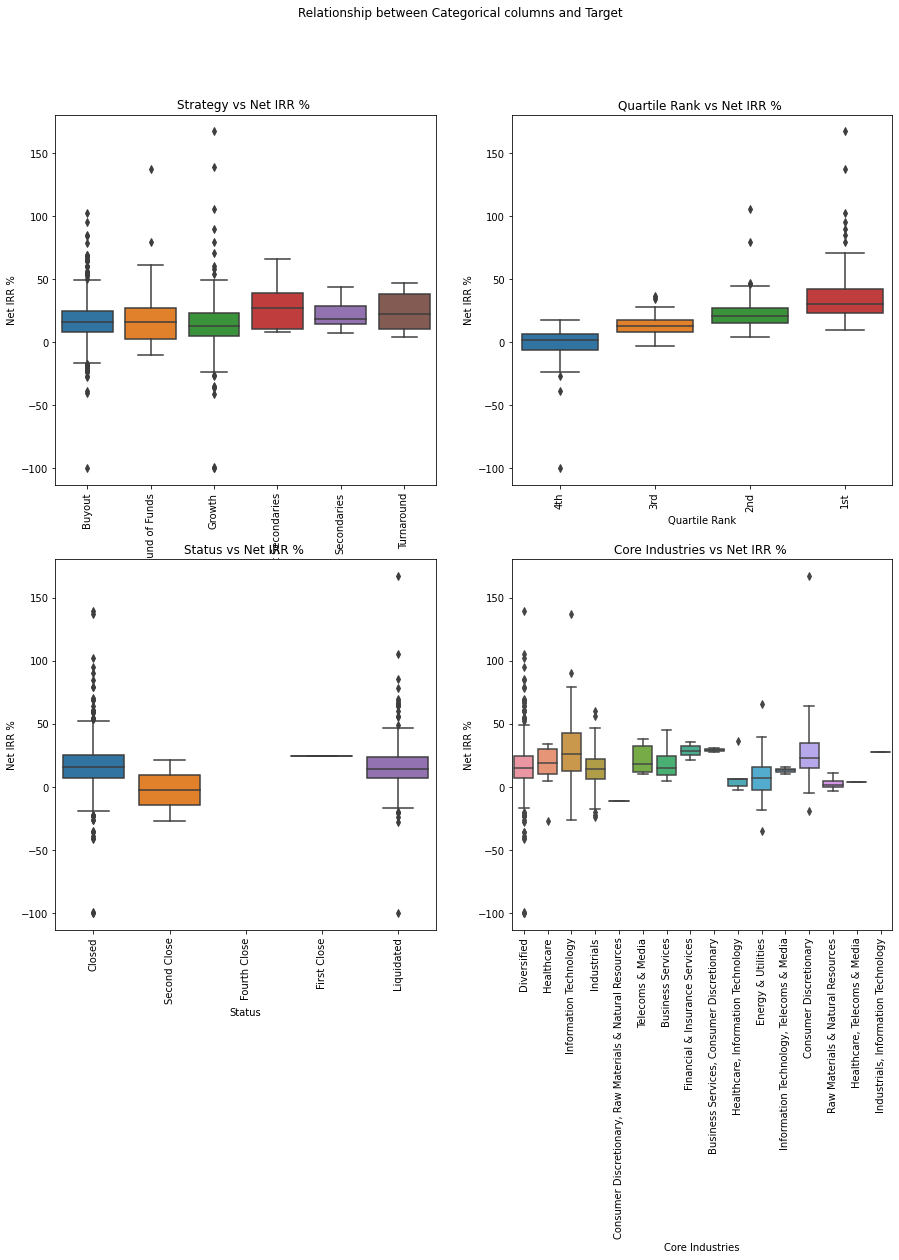

In [ ]:
fig, axes = plt.subplots(2, 2)
fig.suptitle('Relationship between Categorical columns and Target')
for x, y in enumerate(categorical_columns):
  sns.boxplot(ax=axes[x//2, x%2], x=y, y='Net IRR %', data=df)
  axes[x//2, x%2].set_title(f'{y} vs Net IRR % ')
  axes[x//2, x%2].tick_params(axis='x', rotation=90)



In [ ]:
def fillna_numeric(df, columns):
    for i in columns:
        df[i] = df[i].fillna(df[~df[i].isnull()][i].mean())
    return df

In [ ]:
df = df[~df['Net IRR %'].isna()]

In [ ]:
def preprocessing(data, target_column, test_size = 0.2, drop_columns = None):
    if drop_columns is not None:
      for i in drop_columns:
          data = data.drop(columns=i)
    y = data[target_column]
    X = data.drop(columns=[target_column])


    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.8)
    
    data = fillna_numeric(data,numerical_columns)
    preprocessor = make_column_transformer(( OneHotEncoder(handle_unknown='ignore'), categorical_columns), remainder='passthrough')
    num_preprocessor = make_column_transformer(( MinMaxScaler(feature_range=(0, 1)), numerical_columns), remainder='passthrough')
    X_train[numerical_columns] = num_preprocessor.fit_transform(X_train[numerical_columns])
    X_train = preprocessor.fit_transform(pd.DataFrame(X_train))
    X_test[numerical_columns] = num_preprocessor.transform(X_test[numerical_columns])
    X_test = preprocessor.transform(pd.DataFrame(X_test))
    

            
    
    return X_train, X_test, y_train, y_test 

In [ ]:
df['Net IRR %']

4     -40.529116
5     -26.640000
6     -26.400000
7     -22.480000
8     -22.210000
         ...    
902    20.200000
903    24.900000
904    30.340000
905    18.040000
906     4.750000
Name: Net IRR %, Length: 789, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = preprocessing(df,'Net IRR %', drop_columns =drop_columns)

In [ ]:
X_train.shape

(157, 35)

In [ ]:
X_test.shape

(632, 35)

# Model

## XGB

In [ ]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)

[11:44:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [1]:
xgb_metric = mean_absolute_error(xgb_y_pred, y_test)

NameError: ignored

## CATBOOST

In [ ]:
from catboost import CatBoostRegressor
# Initialize data

cat_model = CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=2)
# Fit model
cat_model.fit(X_train, y_train)
# Get predictions
cat_preds = cat_model.predict(X_test)

0:	learn: 15.8062572	total: 433us	remaining: 433us
1:	learn: 13.3256063	total: 1.78ms	remaining: 0us


In [ ]:
cat_metric =mean_absolute_error(cat_preds, y_test)

## LIGHTGBM

In [ ]:
import lightgbm as lgb


In [ ]:
lgb_model = lgb.LGBMRegressor(learning_rate=0.09)
lgb_model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.09)

In [ ]:
lgb_preds = lgb_model.predict(X_test)

In [ ]:
lgb_metric = mean_absolute_error(lgb_preds, y_test)

In [ ]:
model_metrics = {'XGB': xgb_metric, 'CAT': cat_metric, 'LIGHTGBM': lgb_metric}

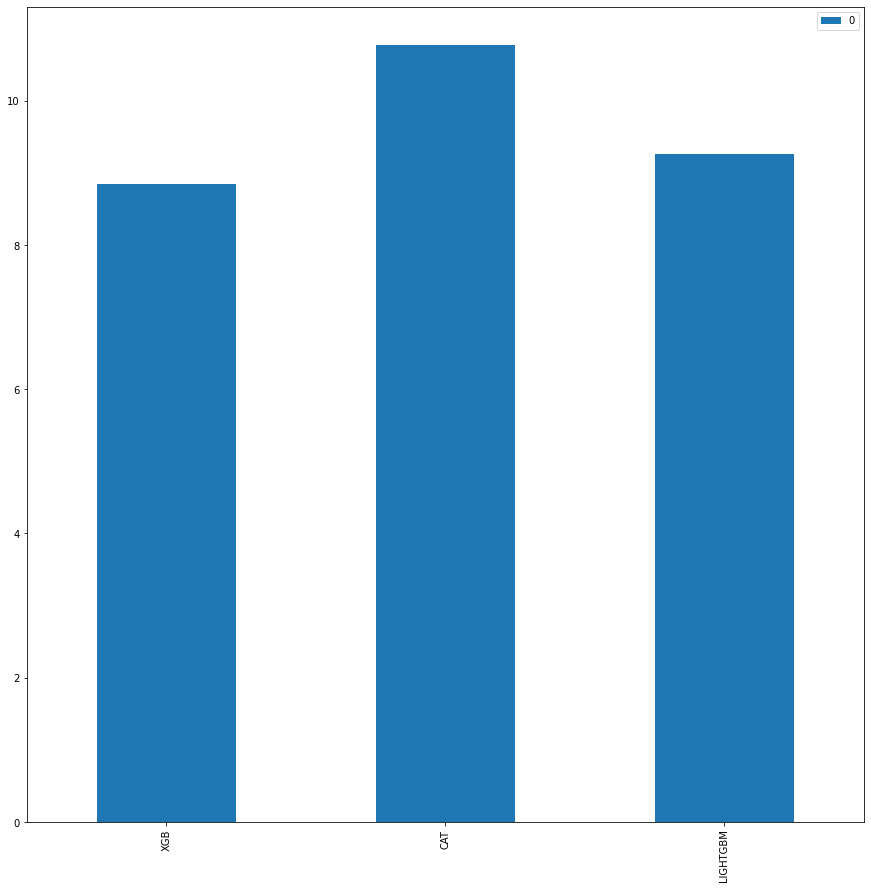

In [ ]:
ax = pd.DataFrame(model_metrics.values(), model_metrics.keys()).plot.bar()